In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

In [3]:
from sim_utils import get_corr_sim, generate_invariant_data, model_corr_noise
from plot_utils import plot_ground_truth_heatmap
from plot_utils import get_sim_color_map, plot_col_color_heatmap
from main_methods import run_procedure
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin
import umap
from plot_utils import plot_scatter_discrete
from collections import Counter
from io_utils import load_data_from_file
from plot_utils import plot_by_noise_struct


ddir = '/share/PI/sabatti/feat_viz/corr_sim/'
fdir = '/scratch/PI/sabatti/spatial_subplots/'


logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

def compute_embedding(mtx, sel_idx=None):
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(mtx.shape[0])
    print("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    return df

def compute_all_embeddings(result, c_mtx, x):
    embed_dict = {}
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    for sel in sel_list:
        if sel == "rejected":
            sel_idx = result["rejections"]
        else:
            sel_idx = None
        for mat in mat_list:
            if mat == "coeffient":
                in_mtx = c_mtx
            else:
                in_mtx = x.T
            key = "{}_{}".format(sel, mat)
            print("Computing embedding for: {}".format(key))
            df = compute_embedding(in_mtx, sel_idx=sel_idx)
            embed_dict[key] = df
    return embed_dict

    # plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
    # plt.show()

all_expression
all_coeffient
all_expression
all_coeffient
all_expression
all_coeffient
Saved figure to: /scratch/PI/sabatti/spatial_subplots/scatter_genes_all.pdf


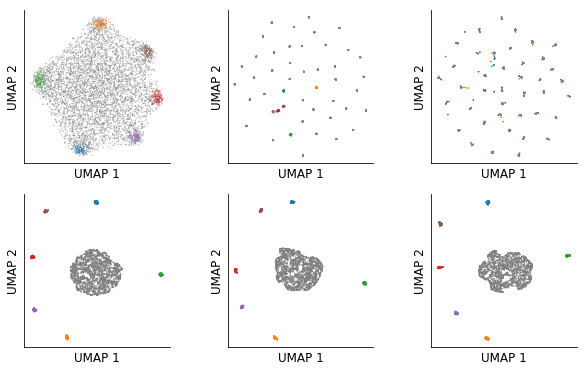

In [4]:
fontsize = 12
n_reg = 3
mat_list = ["expression", "coeffient"]
# sel = 'rejected'
sel = 'all'
n_met = len(mat_list)
fig, axes = plt.subplots(n_met, n_reg, 
                         figsize=(3.3*n_reg, 3.1*n_met))
for i, regime in enumerate(np.arange(n_reg)):
    sim_params = get_corr_sim(regime=regime)
    ddir = sim_params['sim_dir']
    fns = {
        'data_dict': os.path.join(ddir, 'data_dict.pkl'),
        'var_df': os.path.join(ddir, 'var_df.csv'),
        'result': os.path.join(ddir, 'method_result.pkl'),
        'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
        'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    }
    var_df = load_data_from_file(fns['var_df'], 'csv')
    embed_dict = load_data_from_file(fns['embed_dict'], 'pkl')
    
    for j, mat in enumerate(mat_list):
        name = "{}_{}".format(sel, mat)
        print(name)
        plt_df = embed_dict[name]
        ax = axes[j, i]
        var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
        lut = get_sim_color_map(np.unique(var_labs), palette='tab10')
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, 
                              var_labs, 
                              ax=ax, 
                              ms=1.5,
                              alpha=0.6,
                              cols=lut,
                              color_bar=False)
        ax.set_xticks([])
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        ax.set_ylabel("UMAP 2", fontsize=fontsize)
plt.subplots_adjust(wspace=0.4, hspace=0.2)
fn = os.path.join(fdir, 'scatter_genes_{}.pdf'.format(sel))
# fn = os.path.join(fdir, 'scatter_genes_w_bar_{}.pdf'.format(sel))
plt.savefig(fn, bbox_inches='tight', transparent=True) 
print("Saved figure to: {}".format(fn))
plt.show()

Saved figure to: /scratch/PI/sabatti/spatial_subplots/demo_scatter_genes_truth.pdf


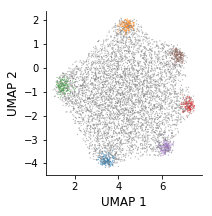

Saved figure to: /scratch/PI/sabatti/spatial_subplots/demo_scatter_genes_gliss.pdf


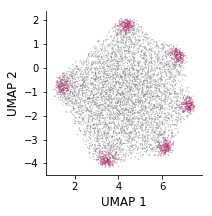

In [7]:
regime = 0
sim_params = get_corr_sim(regime=regime)
ddir = sim_params['sim_dir']
fns = {
    'data_dict': os.path.join(ddir, 'data_dict.pkl'),
    'var_df': os.path.join(ddir, 'var_df.csv'),
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
}
var_df = load_data_from_file(fns['var_df'], 'csv')
embed_dict = load_data_from_file(fns['embed_dict'], 'pkl')
result = load_data_from_file(fns['result'], 'pkl')
sel_idx = result["rejections"]
# coord = embed_dict['all_expression'].values
name = 'all_expression'
plt_df = embed_dict[name]
coord = plt_df[["umap 1", "umap 2"]].values
var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
# selected indices
# sel_labs = var_df.loc[plt_df]
sel_labs = np.zeros(len(var_labs))
sel_labs[sel_idx] = 1
def plot_scatter_for_presentation(coord, cols, lut, fn=None):
    fig, ax = plt.subplots(1, 1, figsize=(3.05, 3.1))
    plot_scatter_discrete(coord, 
                          cols, 
                          ax=ax, 
                          ms=1.5,
                          alpha=0.6,
                          cols=lut,
                          color_bar=False)
    ax.set_xlabel("UMAP 1", fontsize=fontsize)
    ax.set_ylabel("UMAP 2", fontsize=fontsize)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()
fn = os.path.join(fdir, 'demo_scatter_genes_truth.pdf')
plot_scatter_for_presentation(coord, var_labs, lut, fn=fn)
fn = os.path.join(fdir, 'demo_scatter_genes_gliss.pdf')
sel_lut = {0: 'grey', 1: '#C10B66'}
plot_scatter_for_presentation(coord, sel_labs, sel_lut, fn=fn)

# Plot Latent Variable Recovery

In [23]:
from sim_utils import main_corr_sim_evaluation
def load_regime_results(ddir):
    fns = {
        'data_dict': os.path.join(ddir, 'data_dict.pkl'),
        'var_df': os.path.join(ddir, 'var_df.csv'),
        'result': os.path.join(ddir, 'method_result.pkl'),
        'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
        'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    }
    var_df = load_data_from_file(fns['var_df'], 'csv')
    data_dict = load_data_from_file(fns['data_dict'], 'pkl') # {'z': z, 'x': x, 'lam': lam_true}
    true_lam = data_dict['lam']
    result = load_data_from_file(fns['result'], 'pkl')
    return var_df, true_lam, result

mddir = '/share/PI/sabatti/feat_viz/corr_sim/'
n_grps = len(sim_params['z_param']['spike_grp'])
n_per_grp = len(sim_params['z_param']['rel_noise_list'])
n_lm_genes = n_grps * n_per_grp
print('LM genes: {}'.format(n_lm_genes))
# aggregate regime results
main_dd = {}
main_out_dict = {}
# main_order = {}
for regime in range(3):
    print('')
    ddir =  os.path.join(mddir, 'regime_{}'.format(regime))
    var_df, true_lam, result = load_regime_results(ddir)
    n_used_genes = len(result["rejections"]) + n_lm_genes
    n_tot_genes = var_df.shape[0] + n_lm_genes
    # evaluate correlations
    print('Regime: {}; GLISS SV genes: {} / {}'.format(regime, n_used_genes, n_tot_genes))
    dd = {}
    out_dict = {'FDP': {}, 'Power': {}, 'Num_Rejections': {}}
    for method in ['ours', 'palantir', 'paga']:
        if method == 'ours':
            for name in ['lam_init', 'lam_update']:
                lam = result[name]
                corr = abs(spearmanr(lam, true_lam).correlation)
                if name == 'lam_init':
                    use_name = 'naive'
                    rej_idx = []
                else:
                    use_name = 'ours'
                    rej_idx = result["rejections"]
                print('{}: {:.4f}'.format(name, corr))
                res = main_corr_sim_evaluation(rej_idx, sim_params, var_df)
                dd[use_name] = corr
                for metric in out_dict:
                    out_dict[metric][use_name] = res[metric] 
        else:
            for sfx in ['', '_SV_only']:
                use_name = '{}{}'.format(method, sfx)
                fn = os.path.join(ddir, 'ti_{}_result{}.csv'.format(method, sfx))
                out_df = pd.read_csv(fn, index_col=0)
                corr = abs(spearmanr(out_df['pseudotime'], true_lam).correlation)
                print('{}: {:.4f}'.format(use_name, corr))
                dd[use_name] = corr
                rej_idx = list(np.arange(var_df.shape[0]))
                res = main_corr_sim_evaluation(rej_idx, sim_params, var_df)
                for metric in out_dict:
                    out_dict[metric][use_name] = res[metric] 
    main_dd[regime] = dd
    print(dd.keys())
    main_out_dict[regime] = out_dict

LM genes: 6

Regime: 0; GLISS SV genes: 922 / 6000
lam_init: 0.8033
lam_update: 0.9985
palantir: 0.9961
palantir_SV_only: 0.9991
paga: 0.9901
paga_SV_only: 0.9923
dict_keys(['naive', 'ours', 'palantir', 'palantir_SV_only', 'paga', 'paga_SV_only'])

Regime: 1; GLISS SV genes: 1086 / 6000
lam_init: 0.7946
lam_update: 0.9977
palantir: 0.9936
palantir_SV_only: 0.9986
paga: 0.9771
paga_SV_only: 0.9914
dict_keys(['naive', 'ours', 'palantir', 'palantir_SV_only', 'paga', 'paga_SV_only'])

Regime: 2; GLISS SV genes: 1707 / 6000
lam_init: 0.8059
lam_update: 0.9950
palantir: 0.8314
palantir_SV_only: 0.9972
paga: 0.6568
paga_SV_only: 0.9890
dict_keys(['naive', 'ours', 'palantir', 'palantir_SV_only', 'paga', 'paga_SV_only'])


In [93]:
def plot_bar_vals(ddict, order, fn=None):
    my_colors = ['#ddccff', '#ffb3b3', '#b3ecff', '#d8ffcc']
    freq_series = pd.Series([ddict[i] for i in order])
    fig, ax = plt.subplots(1, 1, figsize=(3.2,2.0))
    ax = freq_series.plot(kind='bar', color = my_colors, width=0.65, edgecolor='black')
#                           color=plt.cm.Set2(np.arange(len(freq_series))))
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim(0, 1.3)
    ax.set_xticklabels(order, size=10, rotation=90)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    rects = ax.patches

    # Make some labels.
    labels = ['{:.3f}'.format(v) for v in freq_series]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height*1.05, label,
                ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()
    
def plot_line_plot(ax, dd, order, style='ks-', alpha=1,
                   add_text=True, offset=0, use_ticks=True):
    x_vals = []
    y_vals = []
    for i, met in enumerate (order):
        val = dd[met]
        xpos = i+offset
        x_vals.append(xpos)
        y_vals.append(val)
        label = '{:.3f}'.format(val)
        if add_text:
            ax.text(xpos, val*1.1, label,
                    ha='center', va='bottom', fontsize=11)
    ax.plot(x_vals, y_vals, style, alpha=alpha)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim(0.4, 1.3)
    ax.set_xticks(x_vals)
    


Saved figure to: /scratch/PI/sabatti/spatial_subplots/lineplot_lam_reg_sv_0.pdf


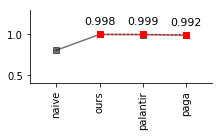

Saved figure to: /scratch/PI/sabatti/spatial_subplots/lineplot_lam_reg_sv_1.pdf


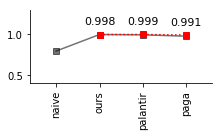

Saved figure to: /scratch/PI/sabatti/spatial_subplots/lineplot_lam_reg_sv_2.pdf


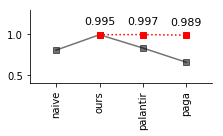

In [101]:
def plot_custom_line_vals(ddict, fn=None):
    order1 = ['ours', 'palantir_SV_only', 'paga_SV_only']
    order2 = ['naive', 'ours', 'palantir', 'paga']
    margin = 0.6
    fig, ax = plt.subplots(1, 1, figsize=(3.2,2.0))
    plot_line_plot(ax, ddict, order2, style='ks-', alpha=0.55, add_text=False)
#     ax.set_xticklabels(order2, size=10, rotation=90)
    plot_line_plot(ax, ddict, order1, offset=1, style='rs:', add_text=True)
    ax.set_xticks(np.arange(len(order2)))
    ax.set_xticklabels(order2, size=10, rotation=90)
    ax.set_xlim(-margin, len(order)-1+margin)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()

for regime in range(3):
    out_dict = main_out_dict[regime]
    dd = main_dd[regime]
    fig_fn = os.path.join(fdir, 'lineplot_lam_reg_sv_{}.pdf'.format(regime))
    plot_custom_line_vals(dd, fn=fig_fn)

Saved figure to: /scratch/PI/sabatti/spatial_subplots/lineplot_lam_reg0.pdf


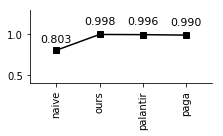

,FDP,Power,Num_Rejections,Use_genes
naive,0.000000,0.000000,0,6
ours,0.026201,0.987778,916,922
palantir,0.720888,1.000000,5994,6000
paga,0.720888,1.000000,5994,6000


Saved figure to: /scratch/PI/sabatti/spatial_subplots/lineplot_lam_reg1.pdf


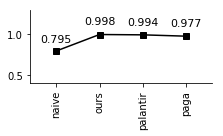

,FDP,Power,Num_Rejections,Use_genes
naive,0.000000,0.000000,0,6
ours,0.024074,0.967778,1080,1086
palantir,0.720888,1.000000,5994,6000
paga,0.720888,1.000000,5994,6000


Saved figure to: /scratch/PI/sabatti/spatial_subplots/lineplot_lam_reg2.pdf


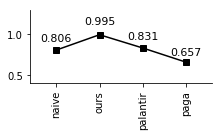

,FDP,Power,Num_Rejections,Use_genes
naive,0.000000,0.00,0,6
ours,0.025279,0.99,1701,1707
palantir,0.720888,1.00,5994,6000
paga,0.720888,1.00,5994,6000


In [96]:
def plot_line_vals(ddict, order, fn=None):
    margin = 0.6
    fig, ax = plt.subplots(1, 1, figsize=(3.2,2.0))
    plot_line_plot(ax, ddict, order, style='ks-', add_text=True)
    ax.set_xlim(-margin, len(order)-1+margin)
    ax.set_xticklabels(order, size=10, rotation=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()
    
for regime in range(3):
    order = ['naive', 'ours', 'palantir', 'paga']
    out_dict = main_out_dict[regime]
    dd = main_dd[regime]
    fig_fn = os.path.join(fdir, 'lineplot_lam_reg{}.pdf'.format(regime))
    plot_line_vals(dd, order, fn=fig_fn)
    df = pd.DataFrame(out_dict).loc[order]
    df['Use_genes'] = df['Num_Rejections'] + n_lm_genes # add LM genes
    display(df)

In [ ]:
for regime in range(3):
    data_name = 'regime_{}'.format(regime)
    ddir =  os.path.join(mddir, data_name)
    fns = {
        'data_dict': os.path.join(ddir, 'data_dict.pkl'),
        'var_df': os.path.join(ddir, 'var_df.csv'),
        'result': os.path.join(ddir, 'method_result.pkl'),
        'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
        'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    }

In [5]:
for regime in range(3):
    sim_params = get_corr_sim(regime=regime)
    ddir = sim_params['sim_dir']
    fns = {
        'data_dict': os.path.join(ddir, 'data_dict.pkl'),
        'var_df': os.path.join(ddir, 'var_df.csv'),
        'result': os.path.join(ddir, 'method_result.pkl'),
        'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
        'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    }
    var_df = load_data_from_file(fns['var_df'], 'csv')
    embed_dict = load_data_from_file(fns['embed_dict'], 'pkl')
    print('Regime {}:'.format(regime))
    print('GLISS')
    print('({} genes)'.format(embed_dict['rejected_expression'].shape[0]+ n_lm_genes))
    print('Total ({} genes)'.format(var_df.shape[0] + n_lm_genes))

LM genes: 6
Regime 0:
GLISS
(922 genes)
Total (6000 genes)
Regime 1:
GLISS
(1086 genes)
Total (6000 genes)
Regime 2:
GLISS
(1707 genes)
Total (6000 genes)


## A Specific Regime

In [11]:
# def run_pipeline(regime):
from sim_utils import selction_eval
regime = 2
sim_params = get_corr_sim(regime=regime)
print(sim_params['null_struct'])
ddir = sim_params['sim_dir']
os.makedirs(ddir, exist_ok=True)
fns = {
    'data_dict': os.path.join(ddir, 'data_dict.pkl'),
    'var_df': os.path.join(ddir, 'var_df.csv'),
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
}
var_df = load_data_from_file(fns['var_df'], 'csv')
embed_dict = load_data_from_file(fns['embed_dict'], 'pkl')
data_dict = load_data_from_file(fns['data_dict'], 'pkl') # {'z': z, 'x': x, 'lam': lam_true}
x = data_dict['x']
z = data_dict['z']
lam_true = data_dict['lam']
result = load_data_from_file(fns['result'], 'pkl')
selction_eval(result, lam_true, sim_params, var_df)
c_mtx = load_data_from_file(fns['coeff_mtx'], 'npy')

{'model': 'normal', 'block_size': 150, 'corr_value': 0.4, 'scale': 0.5, 'seed': 10}
{'FDP': 0.025279247501469725, 'Power': 0.99, 'Corr': 0.9950108920048409, 'Num_Nonnulls': 1673, 'Num_Rejections': 1701}


In [12]:
# params["y_param"]['rel_noise_list'] = [5e-2]
params = sim_params
xspikes = params["z_param"]['spike_grp']
yspikes = params["x_param"]['spike_grp']
yspikes[0], yspikes[1] = yspikes[1], yspikes[0]
yspikes[4], yspikes[5] = yspikes[5], yspikes[4]
x_nlist = [params["x_param"]['rel_noise_list'][0]] + [0]
y_nlist = [params["x_param"]['rel_noise_list'][0]] + [0]
n_plts = len(xspikes) + len(yspikes)

[feat_viz INFO] Saved figure to: /scratch/PI/sabatti/spatial_subplots/main_sim_fig_templates.pdf


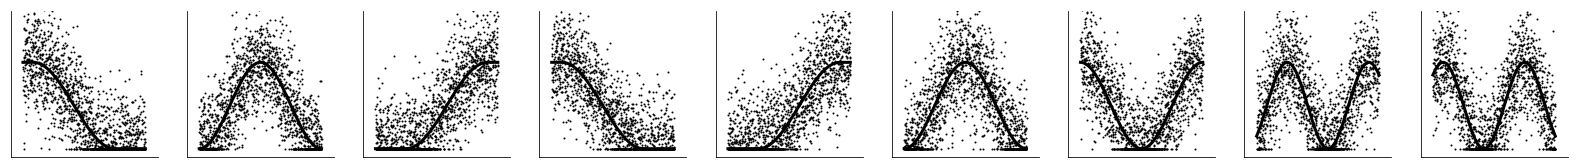

In [13]:
from plot_utils import plot_spikes_examples

fig, axes = plt.subplots(1, n_plts, figsize=(n_plts*3.1, 2.7), sharey=True)
scat_col = "black"
curve_col = "black"

    
for i_spike in range(n_plts):
    ax = axes[i_spike]
    if i_spike < len(xspikes): # predominant variables
        spike = xspikes[i_spike]
#         scat_col = "purple"
#         curve_col = "#23006F"
    else:
        spike = yspikes[i_spike-len(xspikes)]
#         scat_col = "red"
#         curve_col = "#8E0202"
    plot_spikes_examples(ax, spike, x_nlist, 
                         n_samps=params["n_samps"], alpha=1, size=1,
                         scat_col=scat_col, curve_col=curve_col)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.6)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
#     ax.set_ylim(-1.1,1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fn = os.path.join(fdir, 'main_sim_fig_templates.pdf')
if fn:
    plt.savefig(fn, bbox_inches='tight', transparent=True) 
    logger.info("Saved figure to: {}".format(fn))
plt.show()

all_coeffient
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})


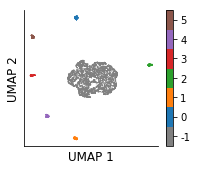

all_expression
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})


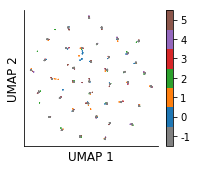

rejected_coeffient
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})


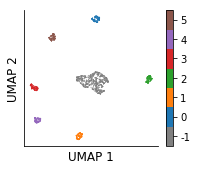

rejected_expression
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})


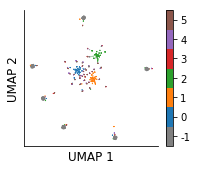

In [14]:
def plot_embeddings(embed_dict, var_df):
    fontsize = 12
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    
    for i, sel in enumerate(sel_list):
        for j, mat in enumerate(mat_list):
            name = "{}_{}".format(sel, mat)
            print(name)
            fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
            plt_df = embed_dict[name]
#             ax = axes[j, i]
            var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
            lut = get_sim_color_map(np.unique(var_labs), palette='tab10')
            print("{}".format(Counter(var_labs)))
            plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1, cols=lut)
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            ax.set_xlabel("UMAP 1", fontsize=fontsize)
            ax.set_ylabel("UMAP 2", fontsize=fontsize)
            plt.show()
plot_embeddings(embed_dict, var_df)

In [15]:
from patsy import dmatrix
def refit_curves(coeff_mtx, base_args, x):
    x = np.linspace(min(x), max(x), 50)
    exog = dmatrix(base_args, {"x": x}, return_type='dataframe')
    y = np.matmul(exog.values, coeff_mtx.T)
    logger.info("Fitted points stored in {}".format(y.shape))
    return x, y
def plot_multi_curves(ax, x, y_mtx, **kwargs):
    assert len(x) == y_mtx.shape[0], "dimension mismatch"
    for i in range(y_mtx.shape[1]):
        ax.plot(x, y_mtx[:,i], **kwargs)

lam = result["lam_update"]
base_args = setup_basis(lam)
np.random.seed(10)
coeff = c_mtx+ 0.1*np.random.normal(size=c_mtx.shape)
x_vals, fit_mtx = refit_curves(coeff, base_args, lam)

[feat_viz INFO] Fitted points stored in (50, 5994)


[feat_viz INFO] Saved figure to: /scratch/PI/sabatti/spatial_subplots/main_sim_fig_clusters.pdf


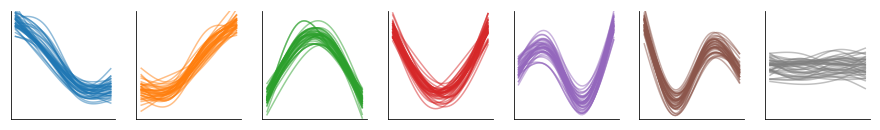

In [16]:
grps = np.unique(var_df.nn_grp)
grps = np.roll(grps, -1)
lut = get_sim_color_map(np.unique(var_labs), palette='tab10')
fig, axes = plt.subplots(1, len(grps), figsize=(2.2*len(grps), 2))

for i, grp in enumerate(grps):
    ax = axes[i]
    ids = var_df.loc[var_df['nn_grp']==grp]['var_id']
#     fig, ax = plt.subplots(1, 1, figsize=(2,2))
    # sub_sample:
    np.random.seed(10)
    ids = np.random.choice(ids, size=40)
    plot_multi_curves(ax, x_vals, fit_mtx[:, ids],
                      alpha=0.5, color=lut[grp])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_ylim(-1.1,1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fn = os.path.join(fdir, 'main_sim_fig_clusters.pdf')
plt.savefig(fn, bbox_inches='tight', transparent=True) 
logger.info("Saved figure to: {}".format(fn))
plt.show()

# More plots on a specifc regime

(1701, 4)
(1701, 4)
(1701, 4)
(1535, 4)


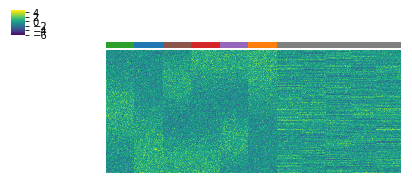

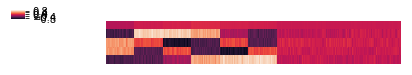

In [23]:
from plot_utils import get_sim_color_map, plot_col_color_heatmap
from sklearn.metrics import pairwise_distances

def get_top_grps(df, num_grps):
    df = df.sort_values('corr_grp') 
    grp_df = df[['corr_grp','var_id']].groupby('corr_grp').size()
    grp_df = grp_df.sort_values(ascending=False)
    use_grp_ids = list(grp_df.index)
    if num_grps:
        use_grp_ids = use_grp_ids[:num_grps]
    df = df.loc[df['corr_grp'].isin(use_grp_ids)]   
    return df

def col_selector(var_df, sel=[], num_grps=None):
    if len(sel) > 0:
        var_df = var_df.loc[sel]
    print(var_df.shape)
    # non-null features
    df_1 = var_df.loc[var_df['nn_grp'] >= 0]
    order = [2, 0, 5, 3, 4, 1]
    df_1_ord = pd.DataFrame()
    for grp in order:
        gdf = df_1.loc[df_1['nn_grp']==grp]
        df_1_ord = pd.concat([df_1_ord, gdf])
    df_1 = df_1_ord
    # null features correlated to the lm genes
    df_2 = var_df.loc[var_df['nn_grp'] == -1]
    df_2 = df_2.loc[df_2['lm_corr']]
    df_2 = get_top_grps(df_2, num_grps)
    # null features uncorrelated with the lm genes
    df_3 = var_df.loc[var_df['nn_grp'] == -1]
    df_3 = df_3.loc[-df_3['lm_corr']]
    df_3 = get_top_grps(df_3, num_grps)
    # combine everything
    if num_grps:
        df = pd.concat([df_1, df_2])
    else:
        df = pd.concat([df_1, df_2, df_3])
    print(df.shape)
    return df
def plot_data_mtx(in_mtx, df, lut, val_min=None, val_max=None, lam=[], 
                  short=False, cmap=None):
    in_mtx = in_mtx[:, df['var_id']]
    grp_ids = df['nn_grp']
    if len(lam) > 0:
        sort_idx = np.argsort(lam)
        in_mtx = in_mtx[sort_idx, :]
    plot_col_color_heatmap(in_mtx, grp_ids, lut, short=short, cmap=cmap)

# plot_ground_truth_heatmap(lam_true, x[:, ])
lut = get_sim_color_map(np.unique(var_df['nn_grp']))
df_sel = col_selector(var_df, sel=result['rejections'])
heat_sel = col_selector(var_df, sel=result['rejections'], num_grps=5)
x[0,0] = -6
plot_data_mtx(x, heat_sel, lut, lam=lam_true, cmap='viridis')
plot_data_mtx(c_mtx.T, heat_sel, lut, short=True, cmap=None)

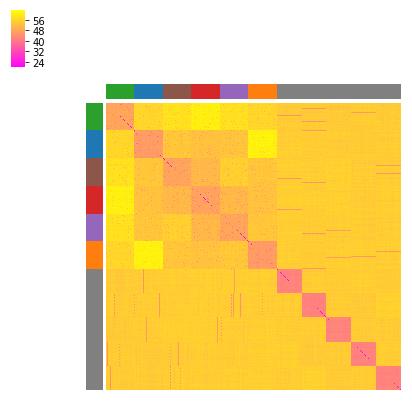

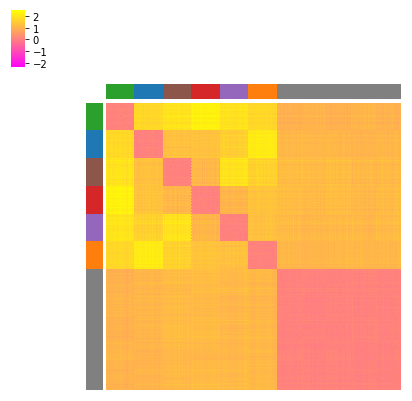

In [30]:


def plot_distance(in_mtx, df, lut, val_min=None, val_max=None):
    in_mtx = in_mtx[:, df['var_id']]
    grp_ids = df['nn_grp']
#     lut = get_sim_color_map(grp_ids)
#     dist_feat = pd.DataFrame(in_mtx).corr(method='spearman')
#     dist_feat = np.exp(-pairwise_distances(in_mtx.T, metric="euclidean")**2)
    dist_feat = pairwise_distances(in_mtx.T, metric="euclidean")
    plot_col_color_heatmap(dist_feat, grp_ids, lut, square=True, 
                           val_min=val_min, val_max=val_max, cmap='spring')
    
plot_distance(x, heat_sel, lut, val_min=20)
plot_distance(c_mtx.T, heat_sel, lut, val_min=-2.4)

# OLD STUFF

In [24]:
heat_sel.head()

,var_id,nn_grp,corr_grp,lm_corr
300,300,2,34,False
301,301,2,27,False
302,302,2,6,False
303,303,2,23,False
304,304,2,26,False


In [ ]:
plot_distance(x, df, lut)

In [ ]:
plot_distance(c_mtx.T, df, lut)

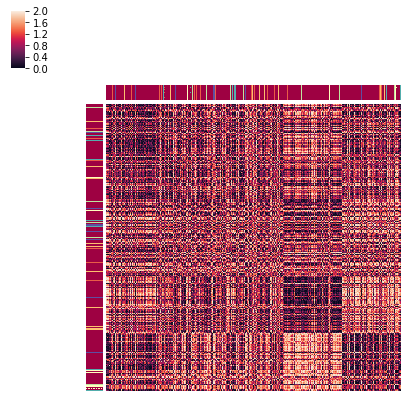

In [47]:
plot_by_noise_struct(var_df, lam_true, c_mtx.T, order_by_noise=True)

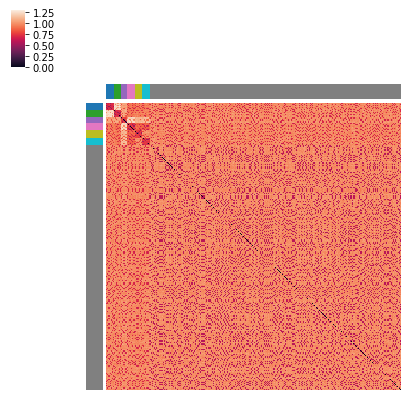

In [57]:
plot_by_noise_struct(var_df, lam_true, x, order_by_noise=False)

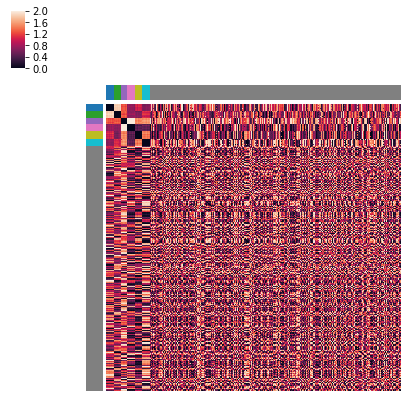

In [58]:
plot_by_noise_struct(var_df, lam_true, c_mtx.T, order_by_noise=False)

{'model': 'normal', 'block_size': 150, 'corr_value': 0.2, 'scale': 0.5, 'seed': 10}
{'FDP': 0.024074074074074074, 'Power': 0.630005977286312, 'Corr': 0.9976637678505634, 'Num_Nonnulls': 1673, 'Num_Rejections': 1080}
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 209, 0: 150, 1: 150, 2: 150, 3: 150, 5: 139, 4: 132})
Counter({-1: 209, 0: 150, 1: 150, 2: 150, 3: 150, 5: 139, 4: 132})


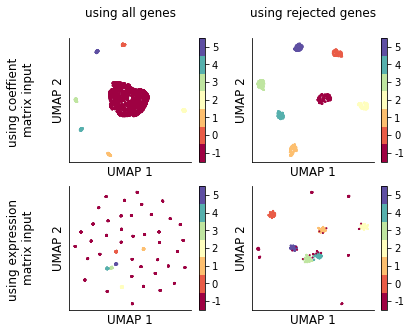

In [10]:
run_pipeline(1)

In [13]:
run_pipeline(0)

NameError: name 'run_pipeline' is not defined